In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imsh, cax=cax, orientation='vertical')

# Test creating networks

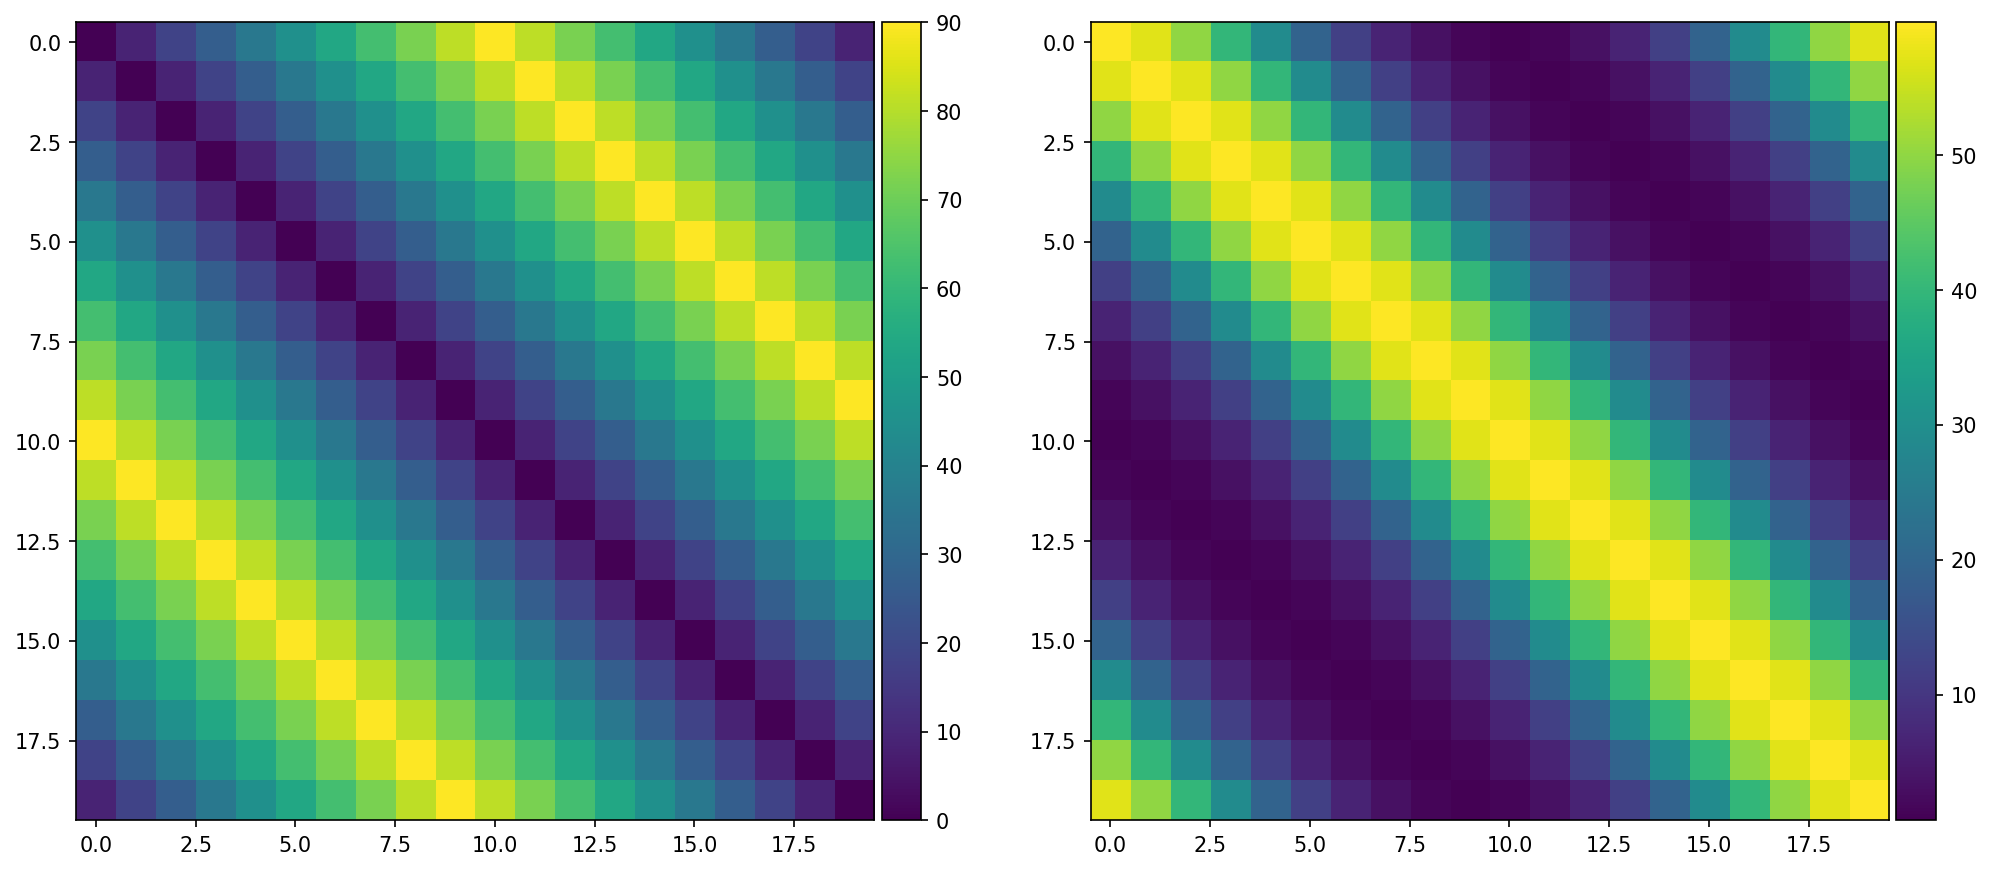

In [3]:
reload(network)

net = network.RingNetwork(Nori=20)

fig,axs = plt.subplots(1,2,figsize=(2*8,8),dpi=150)
imshowbar(fig,axs[0],net.get_ori_diff(True))
imshowbar(fig,axs[1],net.generate_full_kernel(30)*500/net.NC[0])

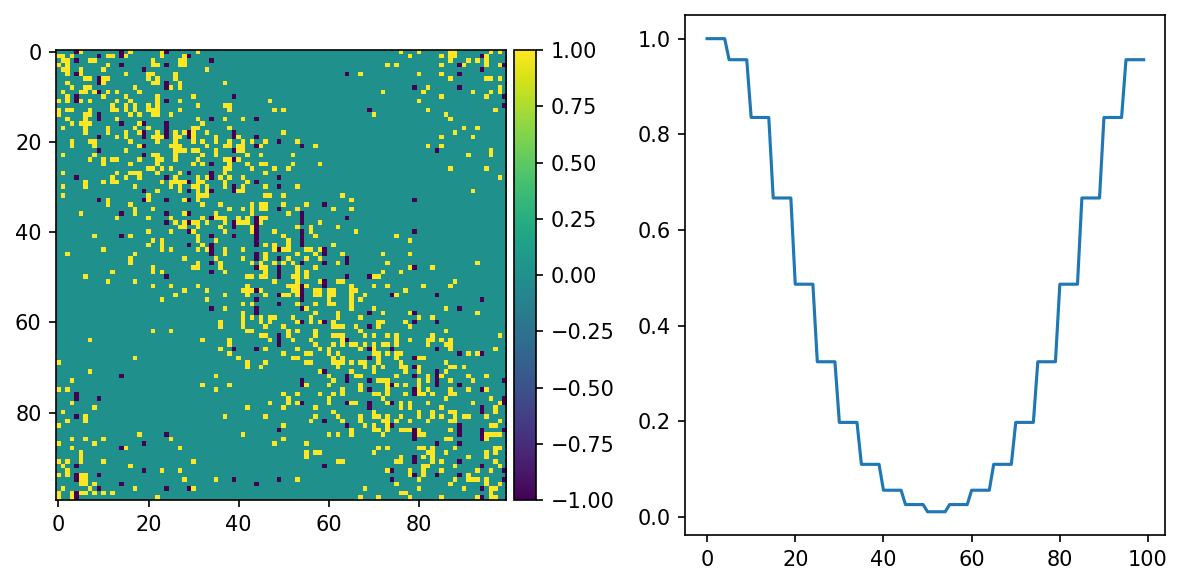

In [4]:
reload(network)

net = network.RingNetwork(NC=[4,1],Nori=20)
net.generate_disorder(np.array([[1,-1],[1,-1]]),30*np.ones((2,2)),
                      np.ones(2),30*np.ones(2),10)

fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=150)
imshowbar(fig,axs[0],net.M,cmap='viridis')
axs[1].plot(net.H)

fig.tight_layout()

# Simulate a ring network

In [5]:
ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')

NtE = 100
T = np.linspace(0,NtE*ri.tE,round(NtE*ri.tE/(ri.tI/3))+1)
mask_time = T>(NtE/2*ri.tE)

Loading previously saved nonlinearity


In [6]:
reload(network)

net = network.RingNetwork(NC=[4,1],Nori=720)
net.generate_disorder(1e-3*np.array([[0.1,-0.8],[0.3,-0.7]]),
                      np.array([[30,20],[30,20]]),
                      500*1e-3*np.array([0.25,0.25]),
                      40*np.ones(2),500)

In [18]:
sol,_ = integ.sim_dyn(ri,T,0.0,net.M,20*net.H,net.H,net.C_all[0],net.C_all[1],mult_tau=True,max_min=30)

5.399199740654059
6.842188388569893


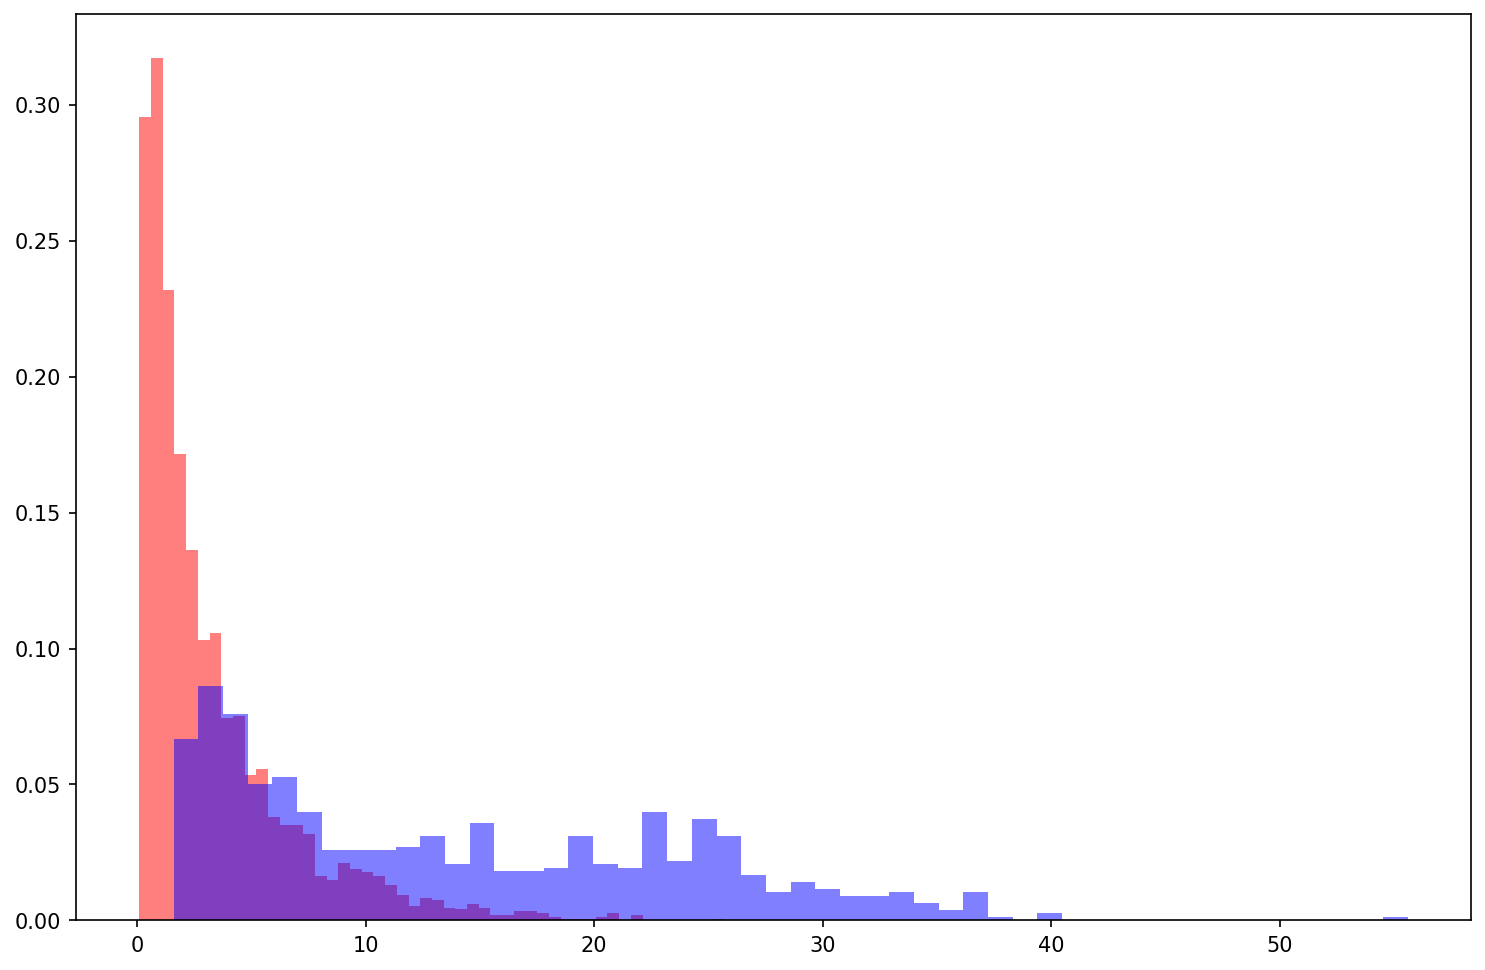

In [20]:
print(np.mean(sol[:,-1]))
print(np.std(sol[:,-1]))

fig,ax = plt.subplots(1,1,figsize=(12,8),dpi=150)

ax.hist(sol[net.C_all[0],-1],50,color='r',alpha=0.5,density=True)
ax.hist(sol[net.C_all[1],-1],50,color='b',alpha=0.5,density=True)

plt.show()

# Investigate scaling, chaos

In [26]:
id = (133, 0)
with open('./../results/results_ring_'+str(id[0])+'.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)[id[1]]
    prms = res_dict['prms']
    eX = res_dict['best_monk_eX']
    bX = res_dict['best_monk_bX']
    aXs = res_dict['best_monk_aXs']
#     K = prms['K']
    SoriE = prms['SoriE']
    SoriI = prms['SoriI']
    SoriF = prms['SoriF']
#     J = prms['J']
#     beta = prms['beta']
#     gE = prms['gE']
#     gI = prms['gI']
#     hE = prms['hE']
#     hI = prms['hI']
#     L = prms['L']
#     CVL = prms['CVL']

ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/3
T = torch.linspace(0,3*Nt,round(3*Nt/dt)+1)
mask_time = T>(2*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 10000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms['Nori'] = Nori
this_prms['NE'] = NE
this_prms['NI'] = NI

Loading previously saved nonlinearity
Using cpu


In [4]:
reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor([0],this_prms,eX)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,(bX*B+aXs[-1]*H)*eps,LAS,net.C_conds[0],mult_tau=True)
rates = torch.mean(sol[:,mask_time],axis=1).cpu().numpy()
dynas = sol[:,mask_time].cpu().numpy()

print("Integrating network took ",time.process_time() - start," s")
print('')

Using cpu
Generating disorder took  7.035756  s

Integrating network took  306.00897  s



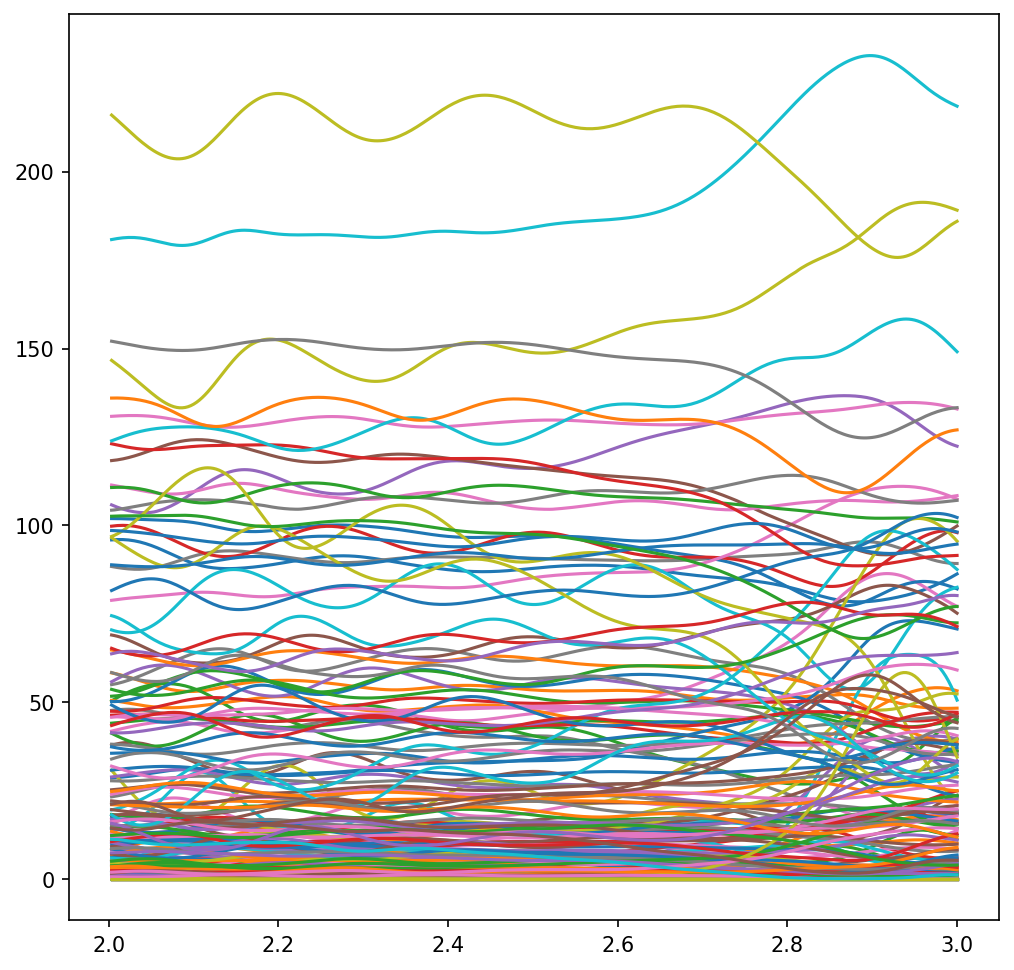

In [5]:
fig,axs = plt.subplots(1,1,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs.plot(T_mask,dynas[::50,:].T)

plt.show()

## Simulate network with finer time resolution

In [6]:
fine_dt = ri.tI/5
fine_T = torch.linspace(0,3*Nt,round(3*Nt/fine_dt)+1)
fine_mask_time = fine_T>(2*Nt)
fine_T_mask = fine_T.cpu().numpy()[fine_mask_time]

start = time.process_time()

fine_sol,_ = integ.sim_dyn_tensor(ri,fine_T,0.0,M,(bX*B+aXs[-1]*H)*eps,LAS,net.C_conds[0],mult_tau=True)
fine_rates = torch.mean(fine_sol[:,fine_mask_time],axis=1).cpu().numpy()
fine_dynas = fine_sol[:,fine_mask_time].cpu().numpy()

print("Integrating network took ",time.process_time() - start," s")
print('')

Integrating network took  306.467768  s



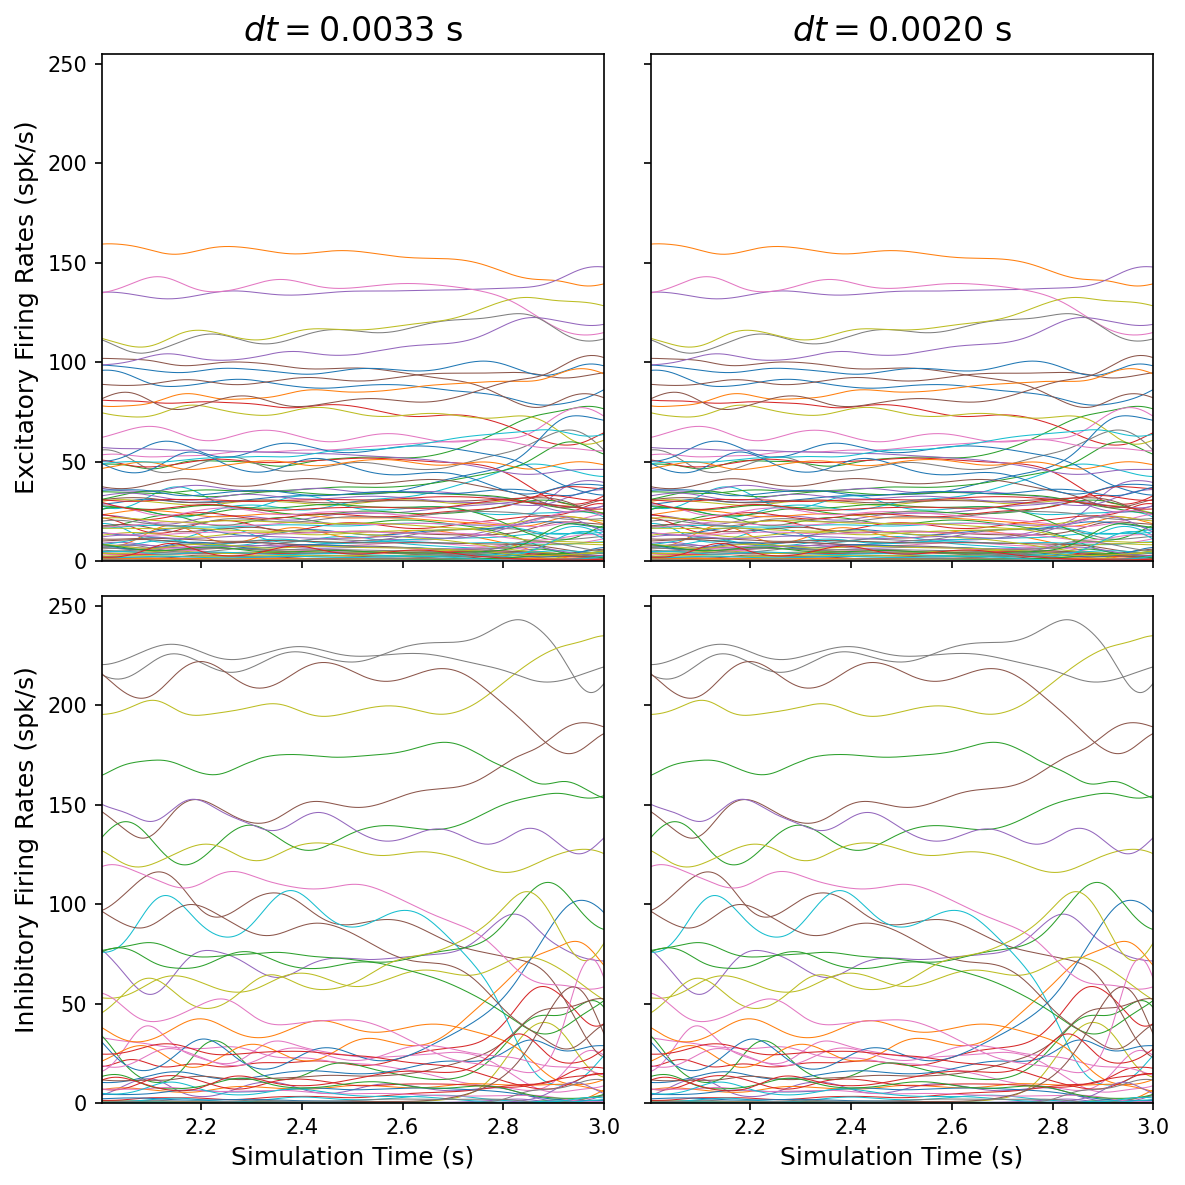

In [7]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs[0,0].plot(T_mask,dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[0,1].plot(fine_T_mask,fine_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[1,0].plot(T_mask,dynas[net.C_all[1],:][::20,:].T,lw=0.5)
axs[1,1].plot(fine_T_mask,fine_dynas[net.C_all[1],:][::20,:].T,lw=0.5)

axs[0,0].set_xlim(min(T_mask),max(T_mask))
axs[0,0].set_ylim(0,None)

axs[1,0].set_xlabel('Simulation Time (s)',fontsize=12)
axs[1,1].set_xlabel('Simulation Time (s)',fontsize=12)

axs[0,0].set_ylabel('Excitatory Firing Rates (spk/s)',fontsize=12)
axs[1,0].set_ylabel('Inhibitory Firing Rates (spk/s)',fontsize=12)

axs[0,0].set_title(r'$dt = 0.0033$ s',fontsize=16)
axs[0,1].set_title(r'$dt = 0.0020$ s',fontsize=16)

fig.tight_layout()
fig.savefig('./../plots/time_discr')

## Simulate dynamics for a longer time over many seeds

In [4]:
long_T = torch.linspace(0,4*Nt,round(4*Nt/dt)+1)
long_mask_time = long_T>(2*Nt)
long_T_mask = long_T.cpu().numpy()[long_mask_time][2::3]

seeds = np.arange(50)
Ms = np.zeros((len(seeds),N,N))
Hs = np.zeros((len(seeds),N))

for seed_idx,seed in enumerate(seeds):
    print('simulating seed # '+str(seed_idx+1))
    print('')
    
    start = time.process_time()

    net,this_M,this_H,this_B,this_LAS,this_eps = su.gen_ring_disorder_tensor(seed,this_prms,eX)
    Ms[seed_idx] = this_M.cpu().numpy()
    Hs[seed_idx] = ((bX*this_B+aXs[-1]*this_H)*this_eps).cpu().numpy()

    print("Generating disorder took ",time.process_time() - start," s")
    print('')
    
long_dynas = np.load('dynas.npy')

simulating seed # 1

Using cpu
Generating disorder took  5.967918  s

simulating seed # 2

Using cpu
Generating disorder took  6.685203  s

simulating seed # 3

Using cpu
Generating disorder took  6.349499000000002  s

simulating seed # 4

Using cpu
Generating disorder took  6.527982999999999  s

simulating seed # 5

Using cpu
Generating disorder took  5.880595  s

simulating seed # 6

Using cpu
Generating disorder took  6.401525999999997  s

simulating seed # 7

Using cpu
Generating disorder took  6.324418000000001  s

simulating seed # 8

Using cpu
Generating disorder took  6.188925999999995  s

simulating seed # 9

Using cpu
Generating disorder took  6.201561999999996  s

simulating seed # 10

Using cpu
Generating disorder took  6.677631000000005  s

simulating seed # 11

Using cpu
Generating disorder took  6.164179000000004  s

simulating seed # 12

Using cpu
Generating disorder took  5.819887999999992  s

simulating seed # 13

Using cpu
Generating disorder took  5.915357  s

simul

OSError: 5000000000 requested and 1879047680 written

In [6]:
# long_T = torch.linspace(0,4*Nt,round(4*Nt/dt)+1)
# long_mask_time = long_T>(2*Nt)
# long_T_mask = long_T.cpu().numpy()[long_mask_time][2::3]

# seeds = np.arange(50)
# Ms = np.zeros((len(seeds),N,N))
# Hs = np.zeros((len(seeds),N))
# long_rates = np.zeros((len(seeds),N))
# long_dynas = np.zeros((len(seeds),N,len(long_T_mask)))

# for seed_idx,seed in enumerate(seeds):
#     print('simulating seed # '+str(seed_idx+1))
#     print('')
    
#     start = time.process_time()

#     net,this_M,this_H,this_B,this_LAS,this_eps = su.gen_ring_disorder_tensor(seed,this_prms,eX)
#     Ms[seed_idx] = this_M.cpu().numpy()
#     Hs[seed_idx] = ((bX*this_B+aXs[-1]*this_H)*this_eps).cpu().numpy()

#     print("Generating disorder took ",time.process_time() - start," s")
#     print('')

#     start = time.process_time()

#     long_sol,_ = integ.sim_dyn_tensor(ri,long_T,0.0,this_M,(bX*this_B+aXs[-1]*this_H)*this_eps,
#                                       this_LAS,net.C_conds[0],mult_tau=True)
#     long_rates[seed_idx] = torch.mean(long_sol[:,long_mask_time],axis=1).cpu().numpy()
#     long_dynas[seed_idx] = long_sol[:,long_mask_time].cpu().numpy()[:,2::3]

#     print("Integrating network took ",time.process_time() - start," s")
#     print('')
    
# np.save('dynas',long_dynas)

simulating seed # 1

Using cpu
Generating disorder took  5.352051  s

Integrating network took  338.13813799999997  s

simulating seed # 2

Using cpu
Generating disorder took  6.547175000000038  s

Integrating network took  208.693511  s

simulating seed # 3

Using cpu
Generating disorder took  6.809668999999985  s

Integrating network took  268.562591  s

simulating seed # 4

Using cpu
Generating disorder took  6.7934439999999086  s

Integrating network took  283.4697920000001  s

simulating seed # 5

Using cpu
Generating disorder took  6.701735999999983  s

Integrating network took  408.71423700000014  s

simulating seed # 6

Using cpu
Generating disorder took  6.423546999999871  s

Integrating network took  179.9983440000001  s

simulating seed # 7

Using cpu
Generating disorder took  6.7810779999999795  s

Integrating network took  373.02929100000006  s

simulating seed # 8

Using cpu
Generating disorder took  6.770744000000377  s

Integrating network took  384.8738639999997  s

si

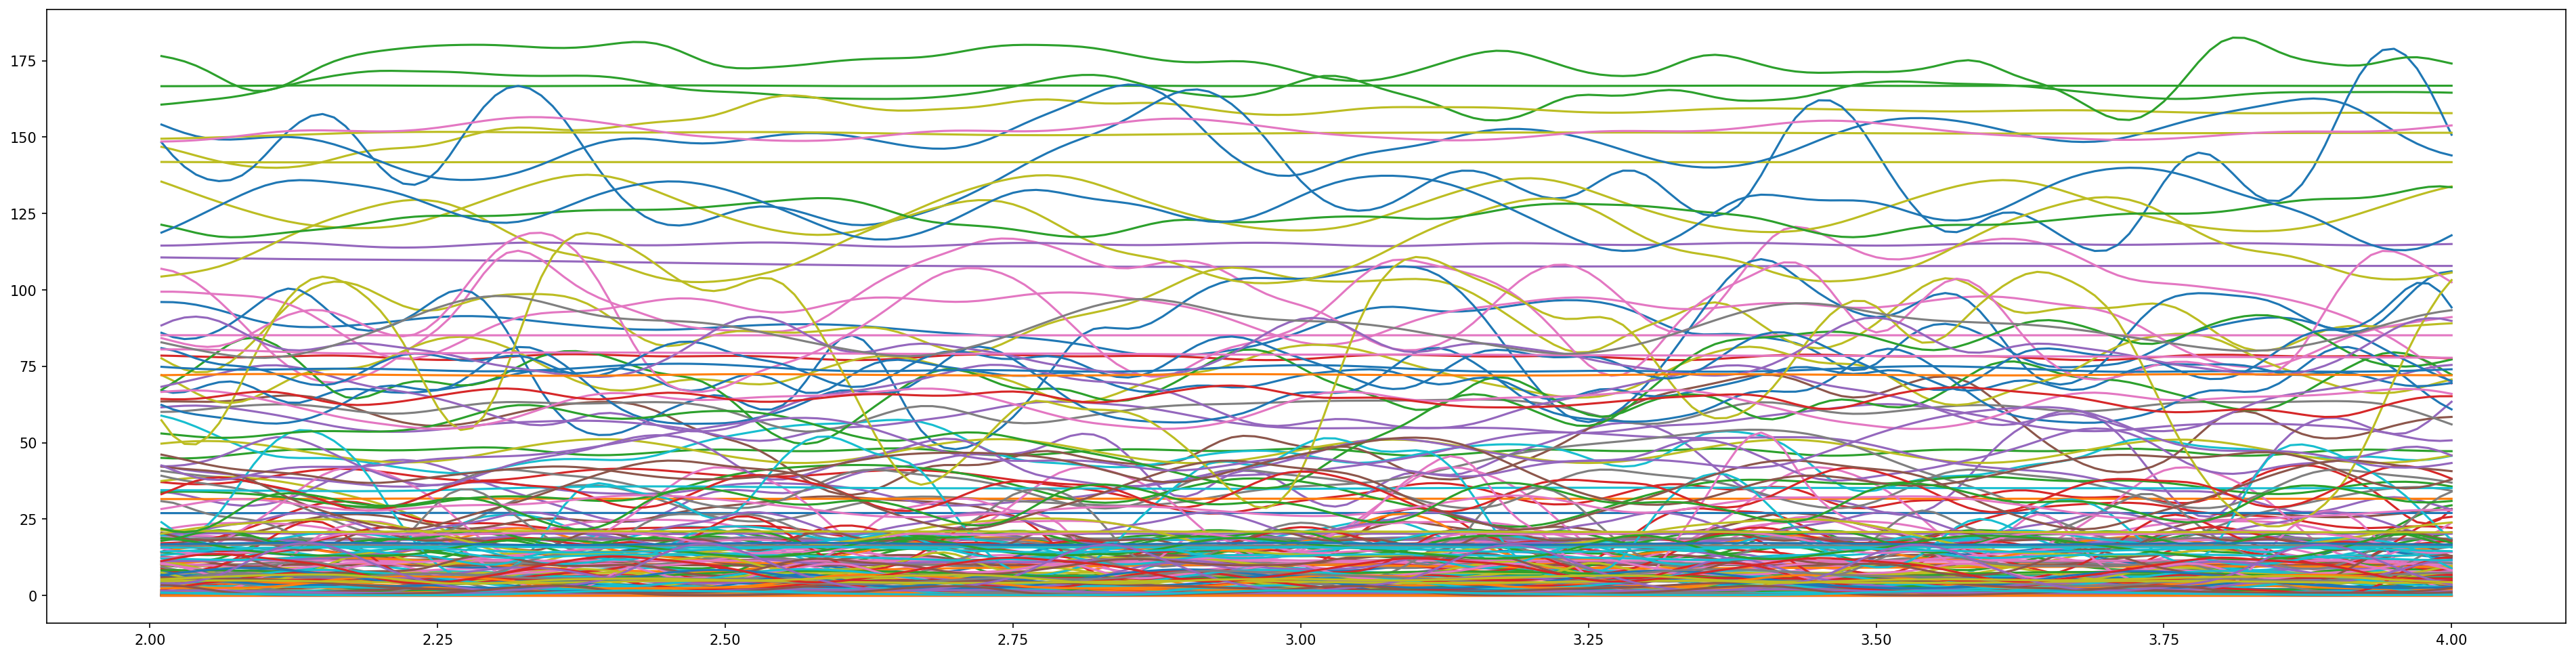

In [9]:
fig,axs = plt.subplots(1,1,figsize=(32,8),dpi=150,sharex=True,sharey=True)

axs.plot(long_T_mask,long_dynas.reshape((-1,len(long_T_mask)))[::2500,:].T)

plt.show()

In [100]:
E_all_idx = net.C_all[0]
I_all_idx = net.C_all[1]

vsm_idx = net.get_oriented_neurons()
E_vsm_idx = np.intersect1d(E_all_idx,vsm_idx)
I_vsm_idx = np.intersect1d(I_all_idx,vsm_idx)

osm_idx = net.get_oriented_neurons(vis_ori=45)
E_osm_idx = np.intersect1d(E_all_idx,osm_idx)
I_osm_idx = np.intersect1d(I_all_idx,osm_idx)

nsm_idx = net.get_oriented_neurons(vis_ori=90)
E_nsm_idx = np.intersect1d(E_all_idx,nsm_idx)
I_nsm_idx = np.intersect1d(I_all_idx,nsm_idx)

## Look at Fourier power spectrum

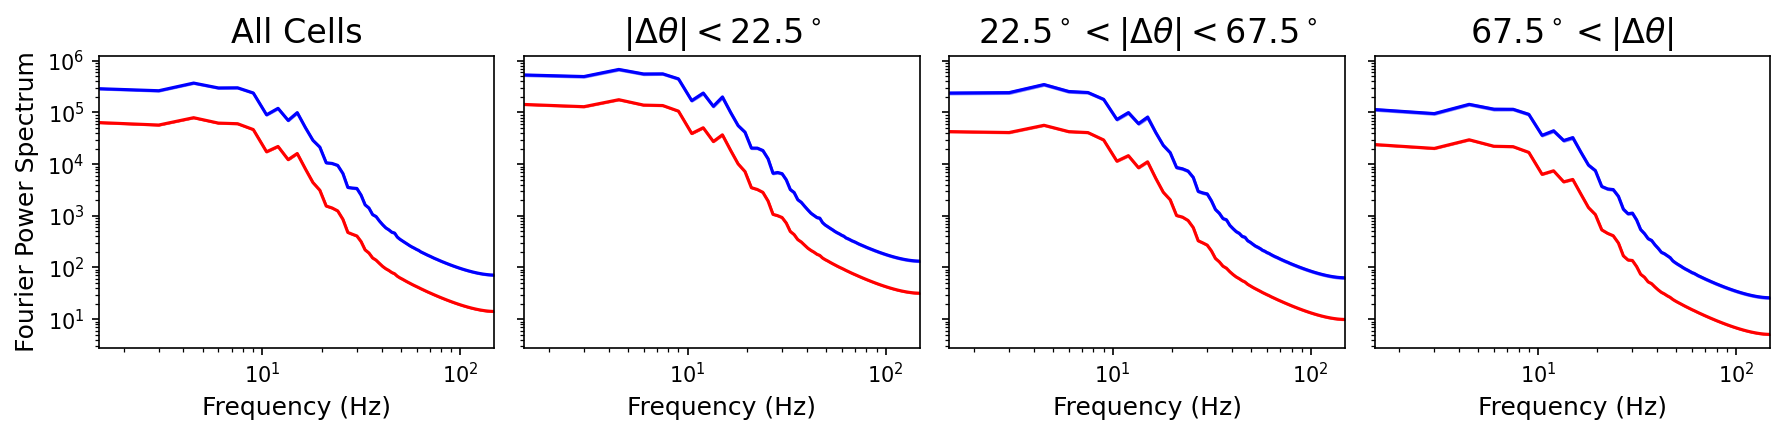

In [10]:
E_all_fps = np.mean(np.abs(np.fft.fft(long_dynas[:,E_all_idx,:],axis=-1))**2,axis=(0,1))
I_all_fps = np.mean(np.abs(np.fft.fft(long_dynas[:,I_all_idx,:],axis=-1))**2,axis=(0,1))
E_all_fps_err = np.std(np.abs(np.fft.fft(long_dynas[:,E_all_idx,:],axis=-1))**2,axis=(0,1)) /\
                                                np.sqrt(len(seeds)*len(E_all_idx))
I_all_fps_err = np.std(np.abs(np.fft.fft(long_dynas[:,I_all_idx,:],axis=-1))**2,axis=(0,1)) /\
                                                np.sqrt(len(seeds)*len(I_all_idx))

E_vsm_fps = np.mean(np.abs(np.fft.fft(long_dynas[:,E_vsm_idx,:],axis=-1))**2,axis=(0,1))
I_vsm_fps = np.mean(np.abs(np.fft.fft(long_dynas[:,I_vsm_idx,:],axis=-1))**2,axis=(0,1))
E_vsm_fps_err = np.std(np.abs(np.fft.fft(long_dynas[:,E_vsm_idx,:],axis=-1))**2,axis=(0,1)) /\
                                                np.sqrt(len(seeds)*len(E_vsm_idx))
I_vsm_fps_err = np.std(np.abs(np.fft.fft(long_dynas[:,I_vsm_idx,:],axis=-1))**2,axis=(0,1)) /\
                                                np.sqrt(len(seeds)*len(I_vsm_idx))

E_osm_fps = np.mean(np.abs(np.fft.fft(long_dynas[:,E_osm_idx,:],axis=-1))**2,axis=(0,1))
I_osm_fps = np.mean(np.abs(np.fft.fft(long_dynas[:,I_osm_idx,:],axis=-1))**2,axis=(0,1))
E_osm_fps_err = np.std(np.abs(np.fft.fft(long_dynas[:,E_osm_idx,:],axis=-1))**2,axis=(0,1)) /\
                                                np.sqrt(len(seeds)*len(E_osm_idx))
I_osm_fps_err = np.std(np.abs(np.fft.fft(long_dynas[:,I_osm_idx,:],axis=-1))**2,axis=(0,1)) /\
                                                np.sqrt(len(seeds)*len(I_osm_idx))

E_nsm_fps = np.mean(np.abs(np.fft.fft(long_dynas[:,E_nsm_idx,:],axis=-1))**2,axis=(0,1))
I_nsm_fps = np.mean(np.abs(np.fft.fft(long_dynas[:,I_nsm_idx,:],axis=-1))**2,axis=(0,1))
E_nsm_fps_err = np.std(np.abs(np.fft.fft(long_dynas[:,E_nsm_idx,:],axis=-1))**2,axis=(0,1)) /\
                                                np.sqrt(len(seeds)*len(E_nsm_idx))
I_nsm_fps_err = np.std(np.abs(np.fft.fft(long_dynas[:,I_nsm_idx,:],axis=-1))**2,axis=(0,1)) /\
                                                np.sqrt(len(seeds)*len(I_nsm_idx))

freqs = np.fft.fftfreq(len(long_T_mask), 3*dt)
idx = freqs > 0

fig,axs = plt.subplots(1,4,figsize=(12,3),dpi=150,sharex=True,sharey=True)

axs[0].plot(freqs[idx],E_all_fps[idx],'r')
axs[0].plot(freqs[idx],I_all_fps[idx],'b')
axs[0].fill_between(freqs[idx],E_all_fps[idx]+E_all_fps_err[idx],
                    E_all_fps[idx]-E_all_fps_err[idx],color='r',alpha=0.5)
axs[0].fill_between(freqs[idx],I_all_fps[idx]+I_all_fps_err[idx],
                    I_all_fps[idx]-I_all_fps_err[idx],color='b',alpha=0.5)

axs[1].plot(freqs[idx],E_vsm_fps[idx],'r')
axs[1].plot(freqs[idx],I_vsm_fps[idx],'b')
axs[1].fill_between(freqs[idx],E_vsm_fps[idx]+E_vsm_fps_err[idx],
                    E_vsm_fps[idx]-E_vsm_fps_err[idx],color='r',alpha=0.5)
axs[1].fill_between(freqs[idx],I_vsm_fps[idx]+I_vsm_fps_err[idx],
                    I_vsm_fps[idx]-I_vsm_fps_err[idx],color='b',alpha=0.5)

axs[2].plot(freqs[idx],E_osm_fps[idx],'r')
axs[2].plot(freqs[idx],I_osm_fps[idx],'b')
axs[2].fill_between(freqs[idx],E_osm_fps[idx]+E_osm_fps_err[idx],
                    E_osm_fps[idx]-E_osm_fps_err[idx],color='r',alpha=0.5)
axs[2].fill_between(freqs[idx],I_osm_fps[idx]+I_osm_fps_err[idx],
                    I_osm_fps[idx]-I_osm_fps_err[idx],color='b',alpha=0.5)

axs[3].plot(freqs[idx],E_nsm_fps[idx],'r')
axs[3].plot(freqs[idx],I_nsm_fps[idx],'b')
axs[3].fill_between(freqs[idx],E_nsm_fps[idx]+E_nsm_fps_err[idx],
                    E_nsm_fps[idx]-E_nsm_fps_err[idx],color='r',alpha=0.5)
axs[3].fill_between(freqs[idx],I_nsm_fps[idx]+I_nsm_fps_err[idx],
                    I_nsm_fps[idx]-I_nsm_fps_err[idx],color='b',alpha=0.5)

axs[0].set_xlim(freqs[1],max(freqs))
axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[0].set_xlabel('Frequency (Hz)',fontsize=12)
axs[1].set_xlabel('Frequency (Hz)',fontsize=12)
axs[2].set_xlabel('Frequency (Hz)',fontsize=12)
axs[3].set_xlabel('Frequency (Hz)',fontsize=12)

axs[0].set_ylabel('Fourier Power Spectrum',fontsize=12)

axs[0].set_title('All Cells',fontsize=16)
axs[1].set_title(r'$|\Delta\theta| < 22.5^\circ$',fontsize=16)
axs[2].set_title(r'$22.5^\circ < |\Delta\theta| < 67.5^\circ$',fontsize=16)
axs[3].set_title(r'$67.5^\circ < |\Delta\theta|$',fontsize=16)

fig.tight_layout()
fig.savefig('./../plots/four_pow_spect')

## Look at cross-correlations

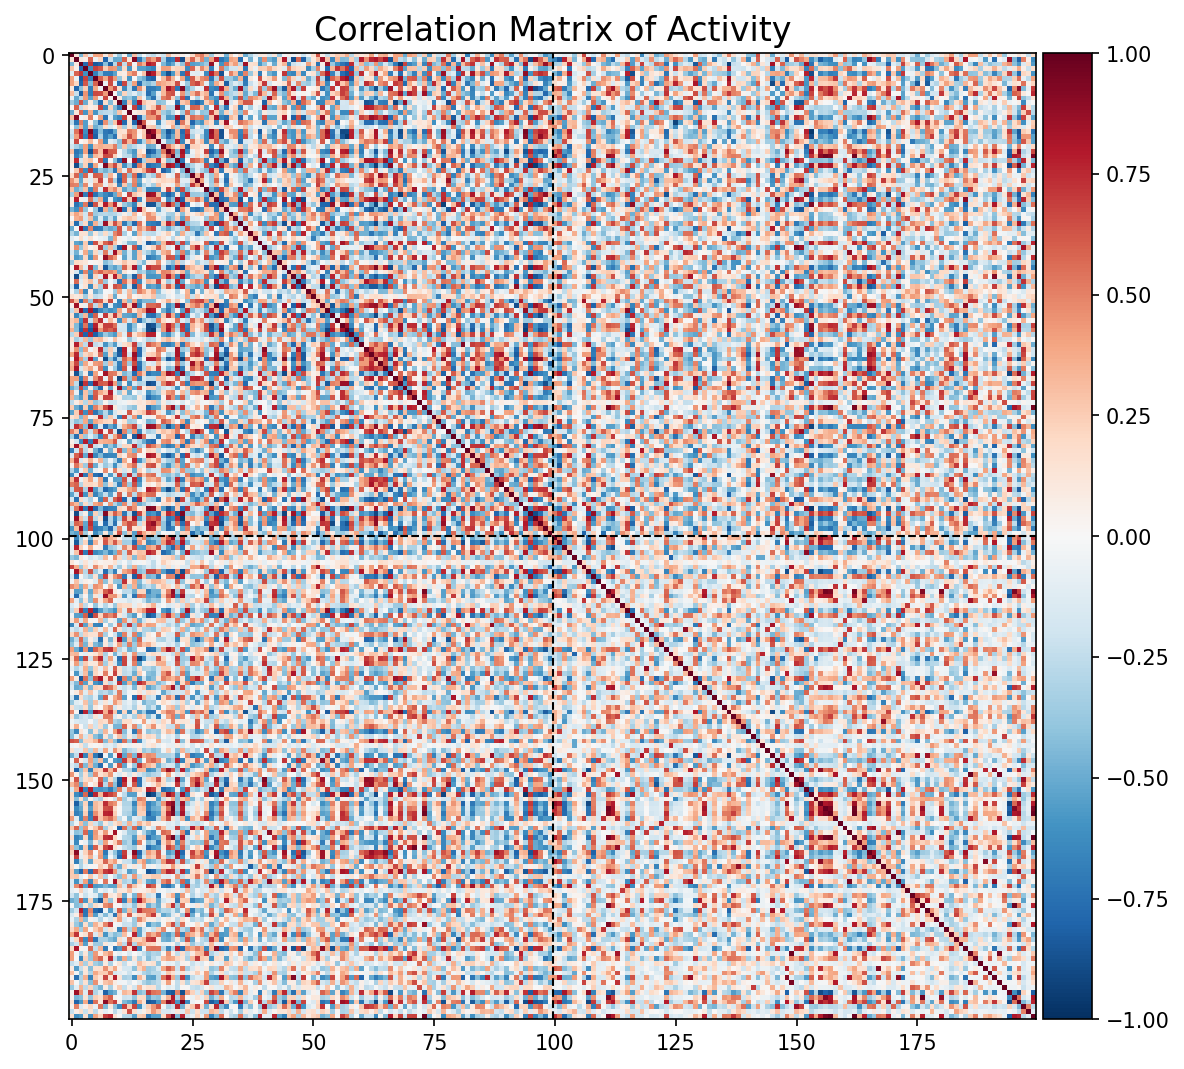

In [11]:
corrs = np.corrcoef(np.vstack((long_dynas[0,E_all_idx,:][::80,:],long_dynas[0,I_all_idx,:][::20,:])))

fig,axs = plt.subplots(1,1,figsize=(8,8),dpi=150,sharex=True,sharey=True)

imshowbar(fig,axs,corrs,cmap='RdBu_r',vmin=-1,vmax=1)

axs.axvline(99.5,c='k',ls='--',lw=1)
axs.axhline(99.5,c='k',ls='--',lw=1)

axs.set_title('Correlation Matrix of Activity',fontsize=16)

fig.tight_layout()
fig.savefig('./../plots/corr_mat')

In [106]:
all_avg = np.zeros(len(seeds))
E_avg = np.zeros(len(seeds))
I_avg = np.zeros(len(seeds))

count = 0
for i in range(len(seeds)):
    print('calculating seed # '+str(i+1))
    all_avg[i] = np.average(np.corrcoef(np.vstack((long_dynas[i,E_all_idx,:],long_dynas[i,I_all_idx,:]))),
                            weights=np.ones((N,N))-np.identity(N))
    E_avg[i] = np.average(np.corrcoef(long_dynas[i,E_all_idx,:]),
                          weights=np.ones((N*4//5,N*4//5))-np.identity(N*4//5))
    I_avg[i] = np.average(np.corrcoef(long_dynas[i,I_all_idx,:]),
                          weights=np.ones((N*1//5,N*1//5))-np.identity(N*1//5))

calculating seed # 1
calculating seed # 2
calculating seed # 3
calculating seed # 4
calculating seed # 5
calculating seed # 6
calculating seed # 7
calculating seed # 8
calculating seed # 9
calculating seed # 10
calculating seed # 11
calculating seed # 12
calculating seed # 13
calculating seed # 14
calculating seed # 15
calculating seed # 16
calculating seed # 17
calculating seed # 18
calculating seed # 19
calculating seed # 20
calculating seed # 21
calculating seed # 22
calculating seed # 23
calculating seed # 24
calculating seed # 25
calculating seed # 26
calculating seed # 27
calculating seed # 28
calculating seed # 29
calculating seed # 30
calculating seed # 31
calculating seed # 32
calculating seed # 33
calculating seed # 34
calculating seed # 35
calculating seed # 36
calculating seed # 37
calculating seed # 38
calculating seed # 39
calculating seed # 40
calculating seed # 41
calculating seed # 42
calculating seed # 43
calculating seed # 44
calculating seed # 45
calculating seed # 

In [107]:
print(np.nanmean(all_avg))
print(np.nanmean(E_avg))
print(np.nanmean(I_avg))

0.0020925594811075613
0.0012318261849437184
0.006286815566582709


## Look at autocorrelation function

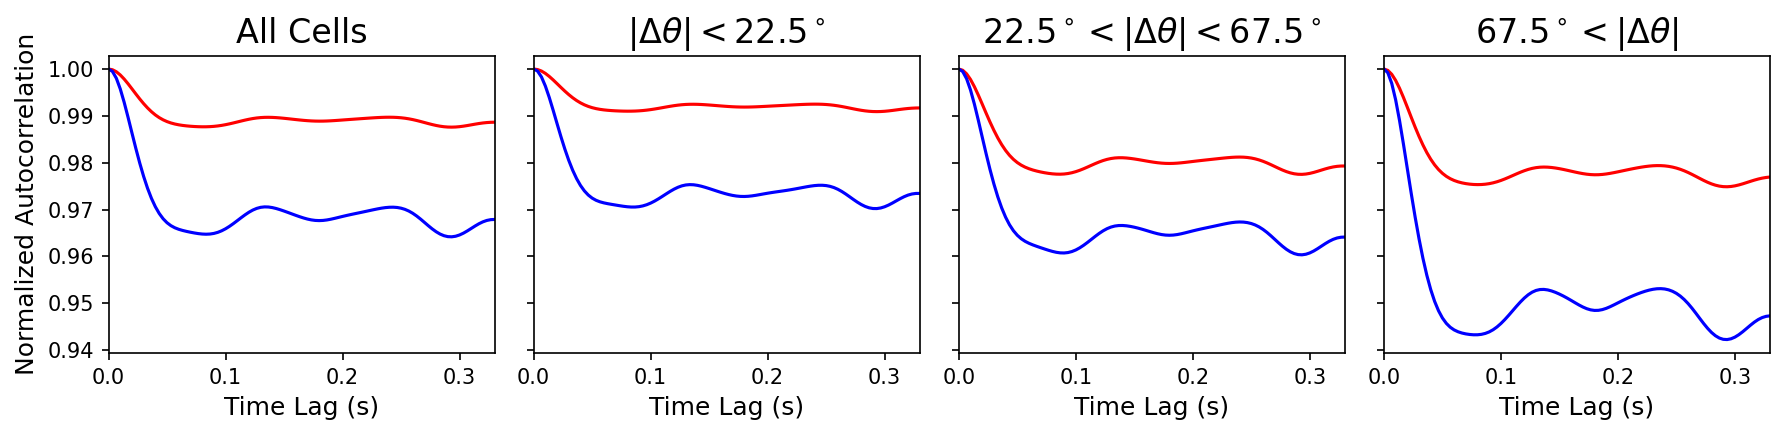

In [10]:
Nacorr = 100
Ncent = len(long_T_mask)-1

E_all_acorr = np.zeros(Nacorr)
for i in range(len(seeds)):
    for j in E_all_idx:
        E_all_acorr += np.correlate(long_dynas[i,j],long_dynas[i,j],'full')[Ncent:Ncent+Nacorr]/\
                                (Ncent+1-np.abs(np.arange(Ncent,Ncent+Nacorr)-Ncent))
E_all_acorr /= len(seeds)*len(E_all_idx)

I_all_acorr = np.zeros(Nacorr)
for i in range(len(seeds)):
    for j in I_all_idx:
        I_all_acorr += np.correlate(long_dynas[i,j],long_dynas[i,j],'full')[Ncent:Ncent+Nacorr]/\
                                (Ncent+1-np.abs(np.arange(Ncent,Ncent+Nacorr)-Ncent))
I_all_acorr /= len(seeds)*len(I_all_idx)

E_vsm_acorr = np.zeros(Nacorr)
for i in range(len(seeds)):
    for j in E_vsm_idx:
        E_vsm_acorr += np.correlate(long_dynas[i,j],long_dynas[i,j],'full')[Ncent:Ncent+Nacorr]/\
                                (Ncent+1-np.abs(np.arange(Ncent,Ncent+Nacorr)-Ncent))
E_vsm_acorr /= len(seeds)*len(E_vsm_idx)

I_vsm_acorr = np.zeros(Nacorr)
for i in range(len(seeds)):
    for j in I_vsm_idx:
        I_vsm_acorr += np.correlate(long_dynas[i,j],long_dynas[i,j],'full')[Ncent:Ncent+Nacorr]/\
                                (Ncent+1-np.abs(np.arange(Ncent,Ncent+Nacorr)-Ncent))
I_vsm_acorr /= len(seeds)*len(I_vsm_idx)

E_osm_acorr = np.zeros(Nacorr)
for i in range(len(seeds)):
    for j in E_osm_idx:
        E_osm_acorr += np.correlate(long_dynas[i,j],long_dynas[i,j],'full')[Ncent:Ncent+Nacorr]/\
                                (Ncent+1-np.abs(np.arange(Ncent,Ncent+Nacorr)-Ncent))
E_osm_acorr /= len(seeds)*len(E_osm_idx)

I_osm_acorr = np.zeros(Nacorr)
for i in range(len(seeds)):
    for j in I_osm_idx:
        I_osm_acorr += np.correlate(long_dynas[i,j],long_dynas[i,j],'full')[Ncent:Ncent+Nacorr]/\
                                (Ncent+1-np.abs(np.arange(Ncent,Ncent+Nacorr)-Ncent))
I_osm_acorr /= len(seeds)*len(I_osm_idx)

E_nsm_acorr = np.zeros(Nacorr)
for i in range(len(seeds)):
    for j in E_nsm_idx:
        E_nsm_acorr += np.correlate(long_dynas[i,j],long_dynas[i,j],'full')[Ncent:Ncent+Nacorr]/\
                                (Ncent+1-np.abs(np.arange(Ncent,Ncent+Nacorr)-Ncent))
E_nsm_acorr /= len(seeds)*len(E_nsm_idx)

I_nsm_acorr = np.zeros(Nacorr)
for i in range(len(seeds)):
    for j in I_nsm_idx:
        I_nsm_acorr += np.correlate(long_dynas[i,j],long_dynas[i,j],'full')[Ncent:Ncent+Nacorr]/\
                                (Ncent+1-np.abs(np.arange(Ncent,Ncent+Nacorr)-Ncent))
I_nsm_acorr /= len(seeds)*len(I_nsm_idx)

lags = np.arange(Nacorr)*dt

fig,axs = plt.subplots(1,4,figsize=(12,3),dpi=150,sharex=True,sharey=True)

axs[0].plot(lags,E_all_acorr/E_all_acorr[0],'r')
axs[0].plot(lags,I_all_acorr/I_all_acorr[0],'b')

axs[1].plot(lags,E_vsm_acorr/E_vsm_acorr[0],'r')
axs[1].plot(lags,I_vsm_acorr/I_vsm_acorr[0],'b')

axs[2].plot(lags,E_osm_acorr/E_osm_acorr[0],'r')
axs[2].plot(lags,I_osm_acorr/I_osm_acorr[0],'b')

axs[3].plot(lags,E_nsm_acorr/E_nsm_acorr[0],'r')
axs[3].plot(lags,I_nsm_acorr/I_nsm_acorr[0],'b')

axs[0].set_xlim(0,max(lags))

axs[0].set_xlabel('Time Lag (s)',fontsize=12)
axs[1].set_xlabel('Time Lag (s)',fontsize=12)
axs[2].set_xlabel('Time Lag (s)',fontsize=12)
axs[3].set_xlabel('Time Lag (s)',fontsize=12)

axs[0].set_ylabel('Normalized Autocorrelation',fontsize=12)

axs[0].set_title('All Cells',fontsize=16)
axs[1].set_title(r'$|\Delta\theta| < 22.5^\circ$',fontsize=16)
axs[2].set_title(r'$22.5^\circ < |\Delta\theta| < 67.5^\circ$',fontsize=16)
axs[3].set_title(r'$67.5^\circ < |\Delta\theta|$',fontsize=16)

fig.tight_layout()
fig.savefig('./../plots/autocorr')

# Look at stability matrix and balance

In [114]:
long_mus = np.zeros_like(long_dynas)
long_muEs = np.zeros_like(long_dynas[:,:,0])
long_muIs = np.zeros_like(long_dynas[:,:,0])

for i in range(len(seeds)):
    print('calculating seed # '+str(i+1))
    long_mus[i] = Ms[i]@long_dynas[i] + Hs[i][:,None]
    long_muEs[i] = np.mean(Ms[i,:,net.C_all[0]].T@long_dynas[i,net.C_all[0],:] + Hs[i][:,None],axis=-1)
    long_muIs[i] = np.mean(Ms[i,:,net.C_all[1]].T@long_dynas[i,net.C_all[1],:],axis=-1)
    
long_mus[:,net.C_all[0],:] *= ri.tE
long_mus[:,net.C_all[1],:] *= ri.tI
long_muEs[:,net.C_all[0]] *= ri.tE
long_muEs[:,net.C_all[1]] *= ri.tI
long_muIs[:,net.C_all[0]] *= ri.tE
long_muIs[:,net.C_all[1]] *= ri.tI

calculating seed # 1
calculating seed # 2
calculating seed # 3
calculating seed # 4
calculating seed # 5
calculating seed # 6
calculating seed # 7
calculating seed # 8
calculating seed # 9
calculating seed # 10
calculating seed # 11
calculating seed # 12
calculating seed # 13
calculating seed # 14
calculating seed # 15
calculating seed # 16
calculating seed # 17
calculating seed # 18
calculating seed # 19
calculating seed # 20
calculating seed # 21
calculating seed # 22
calculating seed # 23
calculating seed # 24
calculating seed # 25
calculating seed # 26
calculating seed # 27
calculating seed # 28
calculating seed # 29
calculating seed # 30
calculating seed # 31
calculating seed # 32
calculating seed # 33
calculating seed # 34
calculating seed # 35
calculating seed # 36
calculating seed # 37
calculating seed # 38
calculating seed # 39
calculating seed # 40
calculating seed # 41
calculating seed # 42
calculating seed # 43
calculating seed # 44
calculating seed # 45
calculating seed # 

In [115]:
long_gain2s = np.zeros_like(long_dynas[0,:,0])
long_bals = np.zeros_like(long_dynas[0,:,0])

long_gain2s[net.C_all[0]] = np.mean(ri.dphiE(long_mus[:,net.C_all[0],:])**2,axis=(0,-1))
long_gain2s[net.C_all[1]] = np.mean(ri.dphiI(long_mus[:,net.C_all[1],:])**2,axis=(0,-1))
long_bals = np.mean(np.abs(long_muEs+long_muIs)/long_muEs,axis=0)

In [117]:
ori_bins = Nori

gain2s = np.zeros(2*ori_bins)
gain2s[:ori_bins] = np.mean(long_gain2s[net.C_all[0]].reshape((ori_bins,Nori*NE//ori_bins)),axis=-1)
gain2s[ori_bins:] = np.mean(long_gain2s[net.C_all[1]].reshape((ori_bins,Nori*NI//ori_bins)),axis=-1)

bals = np.zeros(2*ori_bins)
bals[:ori_bins] = np.mean(long_bals[net.C_all[0]].reshape((ori_bins,Nori*NE//ori_bins)),axis=-1)
bals[ori_bins:] = np.mean(long_bals[net.C_all[1]].reshape((ori_bins,Nori*NI//ori_bins)),axis=-1)

Mpop = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        Mpop[i,j] = np.max(np.abs(Ms[0,net.C_all[i],:][:,net.C_all[j]]))
        if j == 1:
            Mpop[i,j] *= -1

varWs = np.zeros((2*ori_bins,2*ori_bins))

ori_diff = base_net.make_periodic(np.abs(np.arange(ori_bins) - np.arange(ori_bins)[:,None])*180/ori_bins,90)
Ekern = base_net.apply_kernel(ori_diff,SoriE,180,180/ori_bins,kernel='gaussian')
Ikern = base_net.apply_kernel(ori_diff,SoriI,180,180/ori_bins,kernel='gaussian')

varWs[:ori_bins,:ori_bins] = ri.tE**2*500*Mpop[0,0]**2*Ekern
varWs[ori_bins:,:ori_bins] = ri.tI**2*500*Mpop[1,0]**2*Ekern
varWs[:ori_bins,ori_bins:] = ri.tE**2*125*Mpop[0,1]**2*Ikern
varWs[ori_bins:,ori_bins:] = ri.tI**2*125*Mpop[1,1]**2*Ikern

stabM = varWs@np.diag(gain2s)

In [126]:
np.arange(20)/20*180

array([  0.,   9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,
        99., 108., 117., 126., 135., 144., 153., 162., 171.])

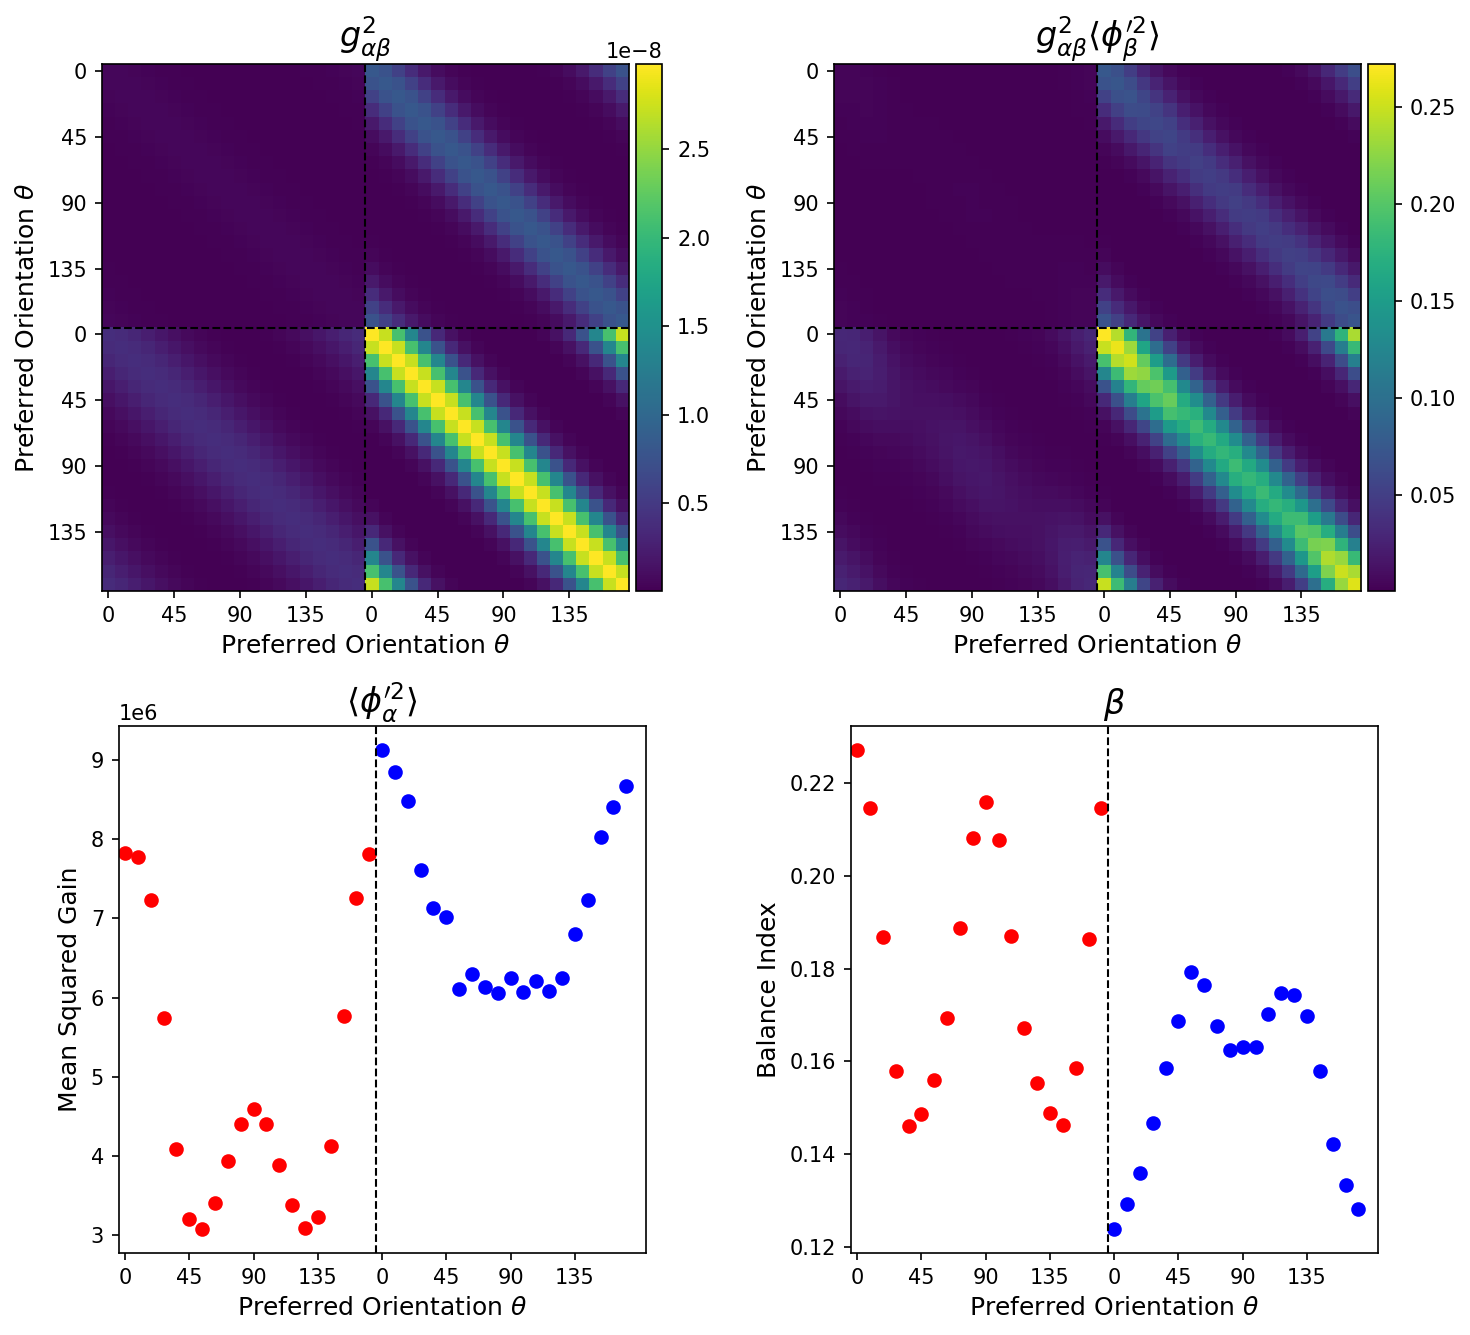

In [142]:
fig,axs = plt.subplots(2,2,figsize=(10,9),dpi=150)
fig.subplots_adjust(hspace=0.3,wspace=0.3)

imshowbar(fig,axs[0,0],varWs)
axs[0,0].axvline(19.5,c='k',ls='--',lw=1)
axs[0,0].axhline(19.5,c='k',ls='--',lw=1)
axs[0,0].set_xticks([0,5,10,15,20,25,30,35],[0,45,90,135,0,45,90,135])
axs[0,0].set_yticks([0,5,10,15,20,25,30,35],[0,45,90,135,0,45,90,135])

imshowbar(fig,axs[0,1],stabM)
axs[0,1].axvline(19.5,c='k',ls='--',lw=1)
axs[0,1].axhline(19.5,c='k',ls='--',lw=1)
axs[0,1].set_xticks([0,5,10,15,20,25,30,35],[0,45,90,135,0,45,90,135])
axs[0,1].set_yticks([0,5,10,15,20,25,30,35],[0,45,90,135,0,45,90,135])

axs[1,0].scatter(np.arange(ori_bins),gain2s[:ori_bins],c='r')
axs[1,0].scatter(np.arange(ori_bins,2*ori_bins),gain2s[ori_bins:],c='b')
axs[1,0].set_box_aspect(1)
axs[1,0].axvline(19.5,c='k',ls='--',lw=1)
axs[1,0].set_xlim(-0.5,40.5)
axs[1,0].set_xticks([0,5,10,15,20,25,30,35],[0,45,90,135,0,45,90,135])

axs[1,1].scatter(np.arange(ori_bins),bals[:ori_bins],c='r')
axs[1,1].scatter(np.arange(ori_bins,2*ori_bins),bals[ori_bins:],c='b')
axs[1,1].set_box_aspect(1)
axs[1,1].axvline(19.5,c='k',ls='--',lw=1)
axs[1,1].set_xlim(-0.5,40.5)
axs[1,1].set_xticks([0,5,10,15,20,25,30,35],[0,45,90,135,0,45,90,135])

axs[0,0].set_xlabel(r'Preferred Orientation $\theta$',fontsize=12)
axs[0,1].set_xlabel(r'Preferred Orientation $\theta$',fontsize=12)
axs[1,0].set_xlabel(r'Preferred Orientation $\theta$',fontsize=12)
axs[1,1].set_xlabel(r'Preferred Orientation $\theta$',fontsize=12)

axs[0,0].set_ylabel(r'Preferred Orientation $\theta$',fontsize=12)
axs[0,1].set_ylabel(r'Preferred Orientation $\theta$',fontsize=12)
axs[1,0].set_ylabel(r'Mean Squared Gain',fontsize=12)
axs[1,1].set_ylabel(r'Balance Index',fontsize=12)

axs[0,0].set_title(r'$g^2_{\alpha\beta}$',fontsize=16)
axs[0,1].set_title(r'$g^2_{\alpha\beta}\langle\phi_\beta^{\prime 2}\rangle$',fontsize=16)
axs[1,0].set_title(r'$\langle\phi_\alpha^{\prime 2}\rangle$',fontsize=16)
axs[1,1].set_title(r'$\beta$',fontsize=16)

fig.tight_layout()
fig.savefig('./../plots/stab_mat')

In [91]:
evals,evecs = np.linalg.eig(stabM)

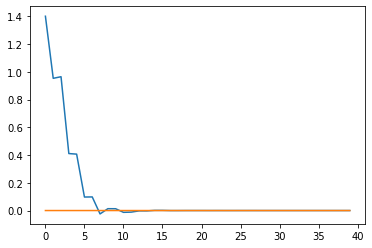

In [92]:
plt.plot(np.real(evals))
plt.plot(np.imag(evals))

In [93]:
evals

array([ 1.40054210e+00+0.00000000e+00j,  9.53130040e-01+0.00000000e+00j,
        9.64559154e-01+0.00000000e+00j,  4.10768010e-01+0.00000000e+00j,
        4.06600932e-01+0.00000000e+00j,  9.73421899e-02+0.00000000e+00j,
        9.80947319e-02+0.00000000e+00j, -2.43500247e-02+0.00000000e+00j,
        1.32819954e-02+0.00000000e+00j,  1.30043628e-02+0.00000000e+00j,
       -1.29764293e-02+0.00000000e+00j, -1.13380925e-02+0.00000000e+00j,
       -2.50626316e-03+0.00000000e+00j, -2.63671554e-03+0.00000000e+00j,
        1.08169249e-03+0.00000000e+00j,  1.08458138e-03+0.00000000e+00j,
       -2.24706604e-04+0.00000000e+00j, -2.22503644e-04+0.00000000e+00j,
        5.13487617e-05+0.00000000e+00j,  5.09566984e-05+0.00000000e+00j,
        4.43581013e-05+0.00000000e+00j, -4.80094381e-05+0.00000000e+00j,
        3.91658322e-05+0.00000000e+00j, -4.54540742e-05+0.00000000e+00j,
       -3.93881347e-05+0.00000000e+00j,  1.72148531e-05+0.00000000e+00j,
        1.72734299e-05+0.00000000e+00j, -2.38028100

# Look at scaling with K

In [181]:
print(bX*10**np.arange(-1.4,0.4+0.1,0.2))
print(np.round(500*10**np.arange(-1.4,0.4+0.1,0.2)).astype(np.int32))

[ 0.20844774  0.3303674   0.52359705  0.8298454   1.31521632  2.0844774
  3.30367403  5.23597049  8.29845398 13.15216322]
[  20   32   50   79  126  199  315  500  792 1256]


In [172]:
rXs = bX*10**np.arange(-4/3,1/3+0.1,1/3)
Ks = np.round(500*10**np.arange(-4/3,1/3+0.1,1/3)).astype(np.int32)

Mevs = np.zeros((len(rXs),len(Ks)))
μrEs = np.zeros((len(rXs),len(Ks)))
μrIs = np.zeros((len(rXs),len(Ks)))
ΣrEs = np.zeros((len(rXs),len(Ks)))
ΣrIs = np.zeros((len(rXs),len(Ks)))
balEs = np.zeros((len(rXs),len(Ks)))
balIs = np.zeros((len(rXs),len(Ks)))

for rXidx,rX in enumerate(rXs):
    for Kidx,K in enumerate(Ks):
        this_K_prms = this_prms.copy()
        this_K_prms['K'] = K
        this_K_prms['J'] = this_prms['J'] / np.sqrt(K/500)

        start = time.process_time()

        net,this_M,this_H,this_B,this_LAS,this_eps = su.gen_ring_disorder_tensor(0,this_K_prms,eX)
        K_M = this_M.cpu().numpy()
        K_H = ((bX*this_B+aXs[-1]*this_H)*this_eps).cpu().numpy()

        print("Generating disorder took ",time.process_time() - start," s")
        print('')

        start = time.process_time()

        K_sol,_ = integ.sim_dyn_tensor(ri,long_T,0.0,this_M,(bX*this_B+aXs[-1]*this_H)*this_eps,
                                          this_LAS,net.C_conds[0],mult_tau=True)
        K_dynas = K_sol[:,long_mask_time].cpu().numpy()[:,2::3]

        K_muEs = K_M[:,net.C_all[0]]@K_dynas[net.C_all[0],:] + K_H[:,None]
        K_muIs = K_M[:,net.C_all[1]]@K_dynas[net.C_all[1],:]
        K_muEs[net.C_all[0],:] *= ri.tE
        K_muEs[net.C_all[1],:] *= ri.tI
        K_muIs[net.C_all[0],:] *= ri.tE
        K_muIs[net.C_all[1],:] *= ri.tI
        K_mus = K_muEs + K_muIs

        print("Integrating network took ",time.process_time() - start," s")
        print('')

        start = time.process_time()

        μrEs[rXidx,Kidx] = np.mean(K_dynas[net.C_all[0],:])
        μrIs[rXidx,Kidx] = np.mean(K_dynas[net.C_all[1],:])
        ΣrEs[rXidx,Kidx] = np.var(K_dynas[net.C_all[0],:])
        ΣrIs[rXidx,Kidx] = np.var(K_dynas[net.C_all[1],:])
        balEs[rXidx,Kidx] = np.mean(np.abs(K_mus[net.C_all[0],:])/K_muEs[net.C_all[0],:])
        balIs[rXidx,Kidx] = np.mean(np.abs(K_mus[net.C_all[1],:])/K_muEs[net.C_all[1],:])

        K_gain2s = np.zeros_like(K_dynas[:,0])

        K_gain2s[net.C_all[0]] = np.mean(ri.dphiE(K_mus[net.C_all[0],:])**2,axis=-1)
        K_gain2s[net.C_all[1]] = np.mean(ri.dphiI(K_mus[net.C_all[1],:])**2,axis=-1)

        gain2s = np.zeros(2*ori_bins)
        gain2s[:ori_bins] = np.mean(K_gain2s[net.C_all[0]].reshape((ori_bins,Nori*NE//ori_bins)),axis=-1)
        gain2s[ori_bins:] = np.mean(K_gain2s[net.C_all[1]].reshape((ori_bins,Nori*NI//ori_bins)),axis=-1)

        Mpop = np.zeros((2,2))
        for i in range(2):
            for j in range(2):
                Mpop[i,j] = np.max(np.abs(K_M[net.C_all[i],:][:,net.C_all[j]]))
                if j == 1:
                    Mpop[i,j] *= -1

        varWs = np.zeros((2*ori_bins,2*ori_bins))

        ori_diff = base_net.make_periodic(np.abs(np.arange(ori_bins) -\
                                                 np.arange(ori_bins)[:,None])*180/ori_bins,90)
        Ekern = base_net.apply_kernel(ori_diff,SoriE,180,180/ori_bins,kernel='gaussian')
        Ikern = base_net.apply_kernel(ori_diff,SoriI,180,180/ori_bins,kernel='gaussian')

        varWs[:ori_bins,:ori_bins] = ri.tE**2*K  *Mpop[0,0]**2*Ekern
        varWs[ori_bins:,:ori_bins] = ri.tI**2*K  *Mpop[1,0]**2*Ekern
        varWs[:ori_bins,ori_bins:] = ri.tE**2*K/4*Mpop[0,1]**2*Ikern
        varWs[ori_bins:,ori_bins:] = ri.tI**2*K/4*Mpop[1,1]**2*Ikern

        stabM = varWs@np.diag(gain2s)

        evals = np.linalg.eigvals(stabM)

        Mevs[rXidx,Kidx] = np.max(np.real(evals))

Using cpu
Generating disorder took  5.788673000000017  s



KeyboardInterrupt: 

In [164]:
fig,axs = plt.subplots(2,2,figsize=(9,8),dpi=150,sharex=True)

axs[0,0].scatter(Ks,μrEs,c='r')
axs[0,0].scatter(Ks,μrIs,c='b')
axs[0,1].scatter(Ks,np.sqrt(ΣrEs),c='r')
axs[0,1].scatter(Ks,np.sqrt(ΣrIs),c='b')
axs[1,0].scatter(Ks,balEs,c='r')
axs[1,0].scatter(Ks,balIs,c='b')
axs[1,1].scatter(Ks,Mevs,c='k')

axs[1,0].set_xlabel('K',fontsize=12)
axs[1,1].set_xlabel('K',fontsize=12)
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,0].set_ylabel('Mean Rates (spk/s)',fontsize=12)
axs[0,1].set_ylabel('Std Rates (spk/s)',fontsize=12)
axs[1,0].set_ylabel('Balance Index',fontsize=12)
axs[1,1].set_ylabel('Largest Stability Eigval',fontsize=12)

fig.tight_layout()
fig.savefig('./../plots/vary_K')